# Random Forest

In [1]:
import numpy as np
import matplotlib.pyplot as plt   
%matplotlib inline
from music21 import *
from IPython.display import Audio
from intervaltree import Interval,IntervalTree
import pandas as pd
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import sklearn.model_selection as model_selection
from sklearn.model_selection import cross_val_score

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from collections import Counter
from imblearn.over_sampling import SMOTE
#from imblearn.over_sampling import SVMSMOTE
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


mn_data = np.load('musicnet.npz','rb',allow_pickle=True)

### Import data

In [2]:
# Import data

#Metadata
metadata = pd.read_csv('cvs_data/musicnet_metadata.csv',index_col=0)

#Wav features only
train_wav = pd.read_csv('cvs_data/df_train_wav_consolidated.csv',index_col=0)
test_wav = pd.read_csv('cvs_data/df_test_wav_finc.csv',index_col=0)

#Midi features only
midi_features = pd.read_csv('cvs_data/midi_features.csv',index_col=0)

In [3]:
meta_data_copy = metadata.copy(deep=True)
meta_data_copy.reset_index(inplace=True)
midi_features_copy = midi_features.copy()

In [48]:
#Make a copy of the metadata
meta_data_copy = metadata.copy(deep=True)
meta_data_copy.reset_index(inplace=True)
midi_features_copy = midi_features.copy()

#Rename column name
meta_data_copy = meta_data_copy.rename(columns = {'id':'filename'})
midi_features_copy = midi_features_copy.rename(columns = {'file_name':'filename'})

#Wav only (w)
merged_train_data_w = train_wav.merge(meta_data_copy,on='filename')
merged_train_data_w = merged_train_data_w.drop(["composer", "composition", "movement","source","transcriber","catalog_name"], axis=1)

merged_test_data_w = test_wav.merge(meta_data_copy,on='filename')
merged_test_data_w = merged_test_data_w.drop(["composer", "composition", "movement","source","transcriber","catalog_name"], axis=1)

#Midi only (m)
merged_train_data_m = train_wav[['filename']].merge(meta_data_copy,on='filename')
merged_train_data_m = merged_train_data_m.drop(["composer", "composition", "movement","source","transcriber","catalog_name"], axis=1)
merged_train_data_m = merged_train_data_m.merge(midi_features_copy,on='filename')

merged_test_data_m = test_wav[['filename']].merge(meta_data_copy,on='filename')
merged_test_data_m = merged_test_data_m.drop(["composer", "composition", "movement","source","transcriber","catalog_name"], axis=1)
merged_test_data_m = merged_test_data_m.merge(midi_features_copy,on='filename')

#Wav & Midi Combined (c)
merged_train_data_c = merged_train_data_w.merge(merged_train_data_m.drop(["ensemble"], axis=1), on='filename')
merged_test_data_c = merged_test_data_w.merge(merged_test_data_m.drop(["ensemble"], axis=1), on='filename')


In [49]:
print(merged_train_data_w.shape, merged_train_data_m.shape , merged_train_data_c.shape)

(320, 169) (320, 12) (320, 179)


In [50]:
print(merged_test_data_w.shape, merged_test_data_m.shape , merged_test_data_c.shape)

(10, 169) (10, 12) (10, 179)


In [51]:
#Subset of dataset for only max 2 instruments

subset_list= ['Accompanied Cello','Accompanied Clarinet','Accompanied Violin','Solo Cello', 'Solo Flute', 'Solo Piano', 'Solo Violin', 'Violin and Harpsichord']

subset_merged_train_data_w = merged_train_data_w.loc[merged_train_data_w['ensemble'].isin(subset_list)]
subset_merged_test_data_w = merged_test_data_w.loc[merged_test_data_w['ensemble'].isin(subset_list)]

subset_merged_train_data_m = merged_train_data_m.loc[merged_train_data_m['ensemble'].isin(subset_list)]
subset_merged_test_data_m = merged_test_data_m.loc[merged_test_data_m['ensemble'].isin(subset_list)]

subset_merged_train_data_c = merged_train_data_c.loc[merged_train_data_c['ensemble'].isin(subset_list)]
subset_merged_test_data_c = merged_test_data_c.loc[merged_test_data_c['ensemble'].isin(subset_list)]

In [52]:
print(subset_merged_train_data_w.shape, subset_merged_train_data_m.shape , subset_merged_train_data_c.shape)

(211, 169) (211, 12) (211, 179)


### Ensembles. Count and mapping to numbers

In [10]:
#Get list of unique ensembles
ens_list = merged_train_data_c['ensemble'].unique()
ens_list

array(['Piano Quintet', 'Solo Piano', 'Piano Trio', 'Viola Quintet',
       'String Quartet', 'Clarinet Quintet',
       'Pairs Clarinet-Horn-Bassoon', 'Wind Quintet', 'Accompanied Cello',
       'Accompanied Clarinet', 'Wind and Strings Octet', 'String Sextet',
       'Piano Quartet', 'Horn Piano Trio', 'Solo Violin', 'Solo Flute',
       'Solo Cello', 'Violin and Harpsichord',
       'Clarinet-Cello-Piano Trio', 'Accompanied Violin', 'Wind Octet'],
      dtype=object)

In [11]:
merged_train_data_c['ensemble'].value_counts()

Solo Piano                     153
String Quartet                  55
Accompanied Violin              21
Solo Cello                      11
Wind Quintet                     9
Piano Quartet                    8
Solo Violin                      8
Piano Trio                       7
Accompanied Cello                7
String Sextet                    5
Pairs Clarinet-Horn-Bassoon      4
Piano Quintet                    4
Accompanied Clarinet             4
Horn Piano Trio                  4
Violin and Harpsichord           4
Wind Octet                       4
Clarinet-Cello-Piano Trio        3
Solo Flute                       3
Clarinet Quintet                 3
Wind and Strings Octet           2
Viola Quintet                    1
Name: ensemble, dtype: int64

In [53]:
#Map list of unique ensemble names to integer
mapping = {item:i for i, item in enumerate(ens_list)}

merged_train_data_w["ensemble"] = merged_train_data_w["ensemble"].apply(lambda x: mapping[x])
subset_merged_train_data_w["ensemble"] = subset_merged_train_data_w["ensemble"].apply(lambda x: mapping[x])

merged_test_data_w["ensemble"] = merged_test_data_w["ensemble"].apply(lambda x: mapping[x])
subset_merged_test_data_w["ensemble"] = subset_merged_test_data_w["ensemble"].apply(lambda x: mapping[x])

merged_train_data_m["ensemble"] = merged_train_data_m["ensemble"].apply(lambda x: mapping[x])
subset_merged_train_data_m["ensemble"] = subset_merged_train_data_m["ensemble"].apply(lambda x: mapping[x])

merged_test_data_m["ensemble"] = merged_test_data_m["ensemble"].apply(lambda x: mapping[x])
subset_merged_test_data_m["ensemble"] = subset_merged_test_data_m["ensemble"].apply(lambda x: mapping[x])

merged_train_data_c["ensemble"] = merged_train_data_c["ensemble"].apply(lambda x: mapping[x])
subset_merged_train_data_c["ensemble"] = subset_merged_train_data_c["ensemble"].apply(lambda x: mapping[x])

merged_test_data_c["ensemble"] = merged_test_data_c["ensemble"].apply(lambda x: mapping[x])
subset_merged_test_data_c["ensemble"] = subset_merged_test_data_c["ensemble"].apply(lambda x: mapping[x])

<ipython-input-53-94bb361f46ab>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_merged_train_data_w["ensemble"] = subset_merged_train_data_w["ensemble"].apply(lambda x: mapping[x])
<ipython-input-53-94bb361f46ab>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_merged_test_data_w["ensemble"] = subset_merged_test_data_w["ensemble"].apply(lambda x: mapping[x])
<ipython-input-53-94bb361f46ab>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [54]:
print(merged_train_data_w.shape, merged_train_data_m.shape , merged_train_data_c.shape)

(320, 169) (320, 12) (320, 179)


In [227]:
#This is the original train test split given in kaggle

X_original_train_w = merged_train_data_w.iloc[:,np.r_[:167,168]]
X_original_test_w = merged_test_data_w.iloc[:,np.r_[:167,168]]

X_original_train_m = merged_train_data_m.iloc[:,np.r_[:,0,2,3,4,5,6,7,8,9,10,11]]
X_original_test_m = merged_test_data_m.iloc[:,np.r_[:,0,2,3,4,5,6,7,8,9,10,11]]

X_original_train_c = merged_train_data_c.iloc[:,np.r_[:167,168,169,170,171,172,173,174,175,176,177,178]]
X_original_test_c = merged_test_data_c.iloc[:,np.r_[:167,168,169,170,171,172,173,174,175,176,177,178]]

y_original_train_w = merged_train_data_w.iloc[:,167:168]
y_original_test_w = merged_test_data_w.iloc[:,167:168]

y_original_train_m = merged_train_data_m.iloc[:,1:2]
y_original_test_m = merged_test_data_m.iloc[:,1:2]

y_original_train_c = merged_train_data_c.iloc[:,167:168]
y_original_test_c = merged_test_data_c.iloc[:,167:168]

In [232]:
print(X_original_train_w.shape, X_original_train_m.shape , X_original_train_c.shape)

(320, 168) (320, 11) (320, 178)


In [233]:
print(y_original_train_w.shape, y_original_train_m.shape , y_original_train_c.shape)

(320, 1) (320, 1) (320, 1)


In [234]:
print(X_original_test_w.shape, X_original_test_m.shape , X_original_test_c.shape)

(10, 168) (10, 11) (10, 178)


In [235]:
print(y_original_test_w.shape, y_original_test_m.shape , y_original_test_c.shape)

(10, 1) (10, 1) (10, 1)


In [236]:
#Concatenate the training and test data
x_frames_w = [X_original_train_w, X_original_test_w]
X_w = pd.concat(x_frames_w, ignore_index=True)

y_frames_w = [y_original_train_w, y_original_test_w]
y_w = pd.concat(y_frames_w, ignore_index=True)

x_frames_m = [X_original_train_m, X_original_test_m]
X_m = pd.concat(x_frames_m, ignore_index=True)

y_frames_m = [y_original_train_m, y_original_test_m]
y_m = pd.concat(y_frames_m, ignore_index=True)

x_frames_c = [X_original_train_c, X_original_test_c]
X_c = pd.concat(x_frames_c, ignore_index=True)

y_frames_c = [y_original_train_c, y_original_test_c]
y_c = pd.concat(y_frames_c, ignore_index=True)


In [237]:
print(X_w.shape, X_m.shape , X_c.shape)

(330, 168) (330, 11) (330, 178)


### Sample split: 80% train and 20% test

In [238]:
#Got an error in splitting the sample saying: ValueError: The least populated class in y has only 1 member, 
# which is too few. The minimum number of groups for any class cannot be less than 2.
#Hence, I proceeded to remove these cases

index_violaquintet = y_w[ y_w['ensemble'] == 3 ].index
index_violaquintet = y_m[ y_m['ensemble'] == 3 ].index
index_violaquintet = y_c[ y_c['ensemble'] == 3 ].index

y_w.drop(index_violaquintet , inplace=True)
X_w.drop(index_violaquintet , inplace=True)
y_m.drop(index_violaquintet , inplace=True)
X_m.drop(index_violaquintet , inplace=True)
y_c.drop(index_violaquintet , inplace=True)
X_c.drop(index_violaquintet , inplace=True)

X_train_w, X_test_w, y_train_w, y_test_w = model_selection.train_test_split(X_w, y_w, train_size=0.80, test_size=0.20, stratify=y_w, random_state=101)
X_train_m, X_test_m, y_train_m, y_test_m = model_selection.train_test_split(X_m, y_m, train_size=0.80, test_size=0.20, stratify=y_m, random_state=101)
X_train_c, X_test_c, y_train_c, y_test_c = model_selection.train_test_split(X_c, y_c, train_size=0.80, test_size=0.20, stratify=y_c, random_state=101)

## 1. Sample as it is: No balancing, no hyperparameter tuning

### 1.a Only WAV data

In [239]:
rf = RandomForestClassifier()
rf.fit(X_train_w, y_train_w)
scores = cross_val_score(estimator = rf, X=X_train_w, y=y_train_w, cv=5, n_jobs=1)
print('Random Forest: Sample as it is: No balancing, no hyperparameter tuning / Only WAV data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

<ipython-input-239-72ad94d6347a>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_w, y_train_w)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estim

Random Forest: Sample as it is: No balancing, no hyperparameter tuning / Only WAV data
CV Scores:  [0.86792453 0.81132075 0.77358491 0.86538462 0.88461538]
CV Average and standard deviation:  0.840566037735849 +/- 0.04158497900934646


<AxesSubplot:>

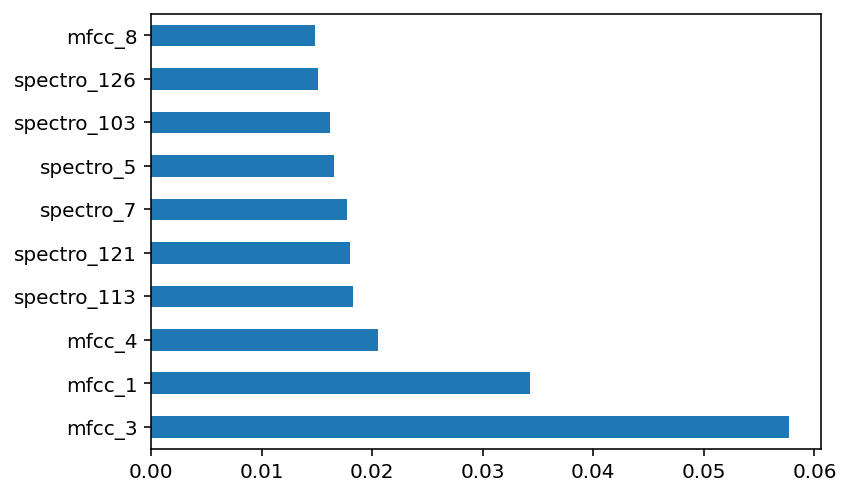

In [240]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train_w.columns)
feat_importances.nlargest(10).plot(kind='barh')

### 1.b Only MIDI data

In [241]:
rf = RandomForestClassifier()
rf.fit(X_train_m, y_train_m)
scores = cross_val_score(estimator = rf, X=X_train_m, y=y_train_m, cv=5, n_jobs=1)
print('Random Forest: Sample as it is: No balancing, no hyperparameter tuning / Only MIDI data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

<ipython-input-241-1cde1d86d140>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_m, y_train_m)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estim

Random Forest: Sample as it is: No balancing, no hyperparameter tuning / Only MIDI data
CV Scores:  [0.88679245 0.94339623 0.9245283  0.92307692 0.94230769]
CV Average and standard deviation:  0.9240203193033383 +/- 0.02047884700217049


<AxesSubplot:>

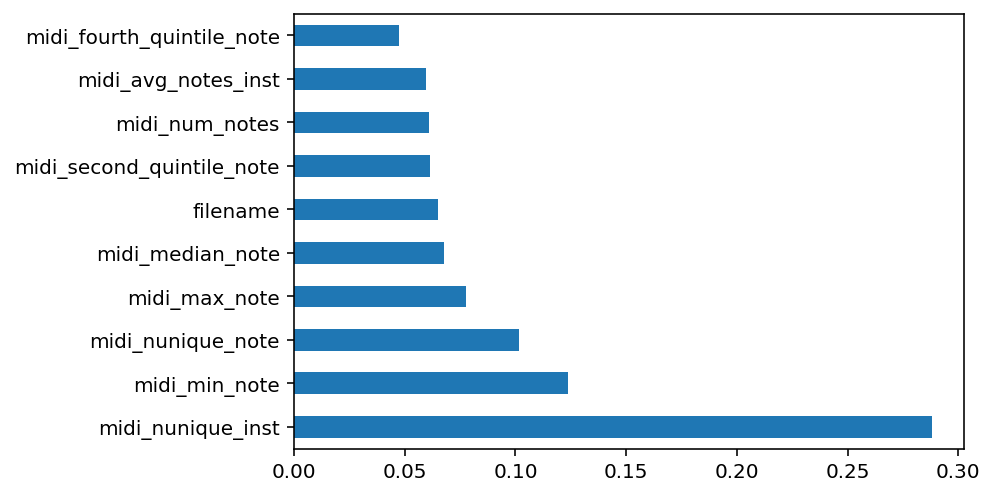

In [242]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train_m.columns)
feat_importances.nlargest(10).plot(kind='barh')

### 1.c Both MIDI & WAV data

In [243]:
rf = RandomForestClassifier()
rf.fit(X_train_c, y_train_c)
scores = cross_val_score(estimator = rf, X=X_train_c, y=y_train_c, cv=5, n_jobs=1)
print('Random Forest: Sample as it is: No balancing, no hyperparameter tuning / Both MIDI & WAV data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

<ipython-input-243-21f69b500943>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_c, y_train_c)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estim

Random Forest: Sample as it is: No balancing, no hyperparameter tuning / Both MIDI & WAV data
CV Scores:  [0.8490566  0.8490566  0.86792453 0.88461538 0.90384615]
CV Average and standard deviation:  0.8708998548621191 +/- 0.02115032944202828


<AxesSubplot:>

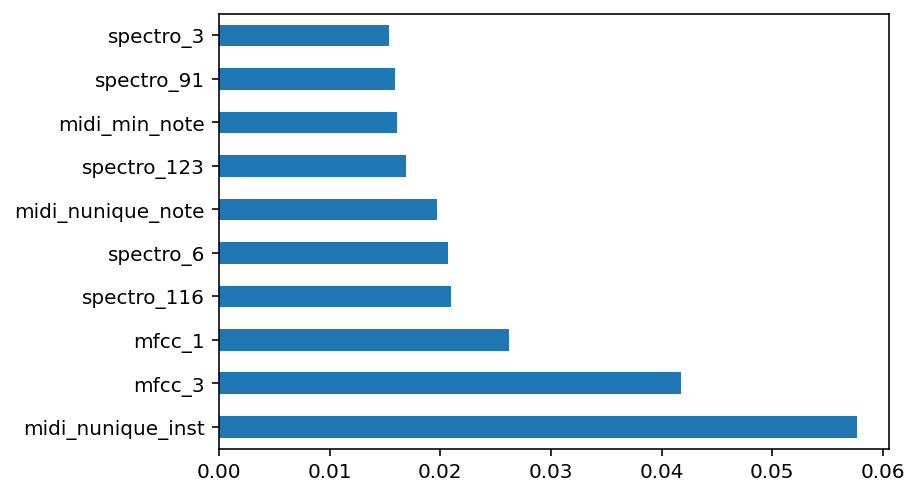

In [244]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train_c.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [ ]:
X_train_w

## 2: Sample with SMOTE, no hyperparameter tuning

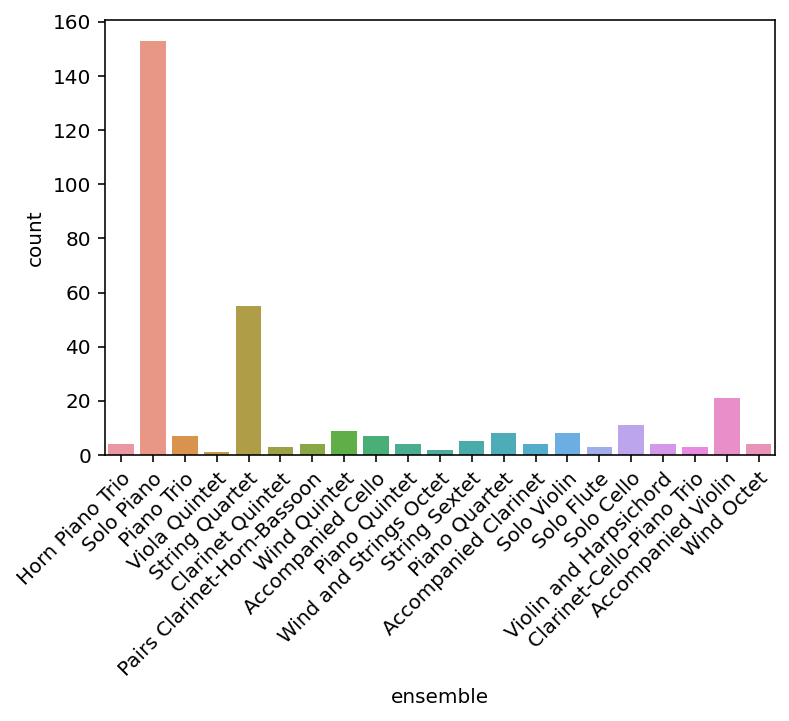

In [245]:
# Visualize the target variable
g = sns.countplot(merged_train_data_w['ensemble'])
g.set_xticklabels(['Horn Piano Trio',
'Solo Piano',
'Piano Trio',
'Viola Quintet',
'String Quartet',
'Clarinet Quintet',
'Pairs Clarinet-Horn-Bassoon',
'Wind Quintet',
'Accompanied Cello',
'Piano Quintet',
'Wind and Strings Octet',
'String Sextet',
'Piano Quartet',
'Accompanied Clarinet',
'Solo Violin',
'Solo Flute',
'Solo Cello',
'Violin and Harpsichord',
'Clarinet-Cello-Piano Trio',
'Accompanied Violin',
'Wind Octet'],rotation_mode='anchor',rotation=45, ha='right')
plt.show()

In [247]:
#Drop any ensemble types with counts below 6. This because Expected n_neighbors <= n_samples,  
#but n_samples = 3, n_neighbors = 6
counts = y_train_w['ensemble'].value_counts()
X_train_w = X_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]
y_train_w = y_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]
print(X_train_w.shape, y_train_w.shape)

counts = y_train_m['ensemble'].value_counts()
X_train_m = X_train_m[~y_train_m['ensemble'].isin(counts[counts < 6].index)]
y_train_m = y_train_m[~y_train_m['ensemble'].isin(counts[counts < 6].index)]
print(X_train_m.shape, y_train_m.shape)

counts = y_train_c['ensemble'].value_counts()
X_train_c = X_train_c[~y_train_c['ensemble'].isin(counts[counts < 6].index)]
y_train_c = y_train_c[~y_train_c['ensemble'].isin(counts[counts < 6].index)]
print(X_train_c.shape, y_train_c.shape)

(231, 168) (231, 1)
(231, 11) (231, 1)
(231, 178) (231, 1)


In [249]:
#Synthetic Minority Oversampling Technique (SMOTE): This technique generates synthetic data for the minority class.

#SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class 
#and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point 
#and its neighbors.


# Fit and apply the transform
X_SMOTE_w, y_SMOTE_w = SMOTE(random_state=101).fit_resample(X_train_w, y_train_w)

print('Original dataset shape', Counter(y_train_w.values.ravel()))
print('Resample dataset shape', Counter(y_SMOTE_w.values.ravel()))

X_SMOTE_m, y_SMOTE_m = SMOTE(random_state=101).fit_resample(X_train_m, y_train_m)

print('Original dataset shape', Counter(y_train_m.values.ravel()))
print('Resample dataset shape', Counter(y_SMOTE_m.values.ravel()))

X_SMOTE_c, y_SMOTE_c = SMOTE(random_state=101).fit_resample(X_train_c, y_train_c)

print('Original dataset shape', Counter(y_train_c.values.ravel()))
print('Resample dataset shape', Counter(y_SMOTE_c.values.ravel()))


Original dataset shape Counter({1: 125, 4: 46, 19: 18, 16: 10, 14: 7, 7: 7, 12: 6, 8: 6, 2: 6})
Resample dataset shape Counter({19: 125, 1: 125, 12: 125, 14: 125, 16: 125, 4: 125, 7: 125, 8: 125, 2: 125})
Original dataset shape Counter({1: 125, 4: 46, 19: 18, 16: 10, 14: 7, 7: 7, 12: 6, 8: 6, 2: 6})
Resample dataset shape Counter({19: 125, 1: 125, 12: 125, 14: 125, 16: 125, 4: 125, 7: 125, 8: 125, 2: 125})
Original dataset shape Counter({1: 125, 4: 46, 19: 18, 16: 10, 14: 7, 7: 7, 12: 6, 8: 6, 2: 6})
Resample dataset shape Counter({19: 125, 1: 125, 12: 125, 14: 125, 16: 125, 4: 125, 7: 125, 8: 125, 2: 125})


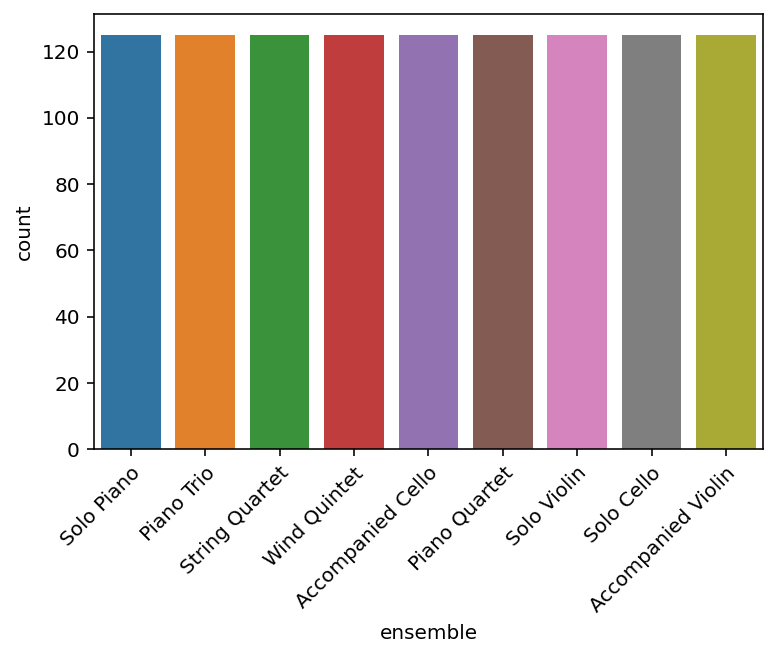

In [250]:
# Visualize the target variable
g = sns.countplot(y_SMOTE_w['ensemble'])
g.set_xticklabels([
'Solo Piano', 
'Piano Trio',
'String Quartet',
'Wind Quintet',
'Accompanied Cello',
'Piano Quartet',
'Solo Violin',
'Solo Cello',
'Accompanied Violin'],rotation_mode='anchor',rotation=45, ha='right')
plt.show()

### 2.a Only WAV data

In [251]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1)
rf.fit(X_SMOTE_w, y_SMOTE_w)
scores = cross_val_score(estimator = rf, X=X_SMOTE_w, y=y_SMOTE_w, cv=5, n_jobs=1)
print('Random Forest: Sample with SMOTE, no hyperparameter tuning / Only WAV data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#Default parameters:
    #n_estimatorsint, default=100
    #max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto”
    #min_samples_splitint or float, default=2


<ipython-input-251-466928e30b6c>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_SMOTE_w, y_SMOTE_w)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

Random Forest: Sample as it is: No balancing, no hyperparameter tuning / Only WAV data
CV Scores:  [0.98222222 0.98222222 0.99555556 1.         0.99555556]
CV Average and standard deviation:  0.9911111111111112 +/- 0.007436978013636222


<AxesSubplot:>

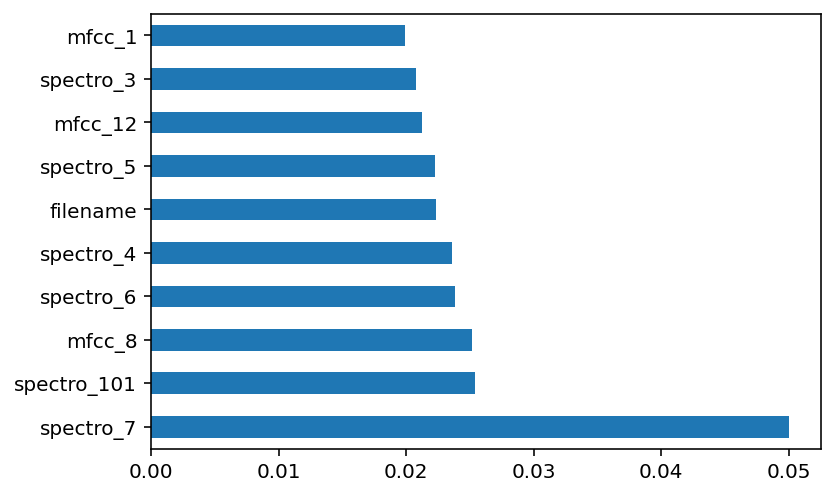

In [252]:
feat_importances = pd.Series(rf.feature_importances_, index=X_SMOTE_w.columns)
feat_importances.nlargest(10).plot(kind='barh')

### 2.b Only MIDI data

In [253]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1)
rf.fit(X_SMOTE_m, y_SMOTE_m)
scores = cross_val_score(estimator = rf, X=X_SMOTE_m, y=y_SMOTE_m, cv=5, n_jobs=1)
print('Random Forest: Sample with SMOTE, no hyperparameter tuning / Only MIDI data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#Default parameters:
    #n_estimatorsint, default=100
    #max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto”
    #min_samples_splitint or float, default=2

<ipython-input-253-2c33181d1fa3>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_SMOTE_m, y_SMOTE_m)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

Random Forest: Sample as it is: No balancing, no hyperparameter tuning / Only MIDI data
CV Scores:  [0.99111111 1.         0.99555556 0.99555556 1.        ]
CV Average and standard deviation:  0.9964444444444445 +/- 0.003325917677132378


<AxesSubplot:>

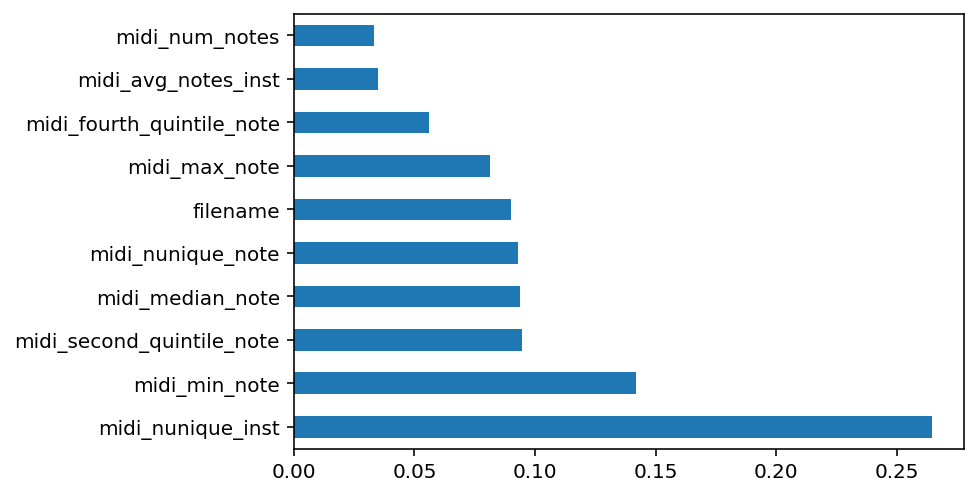

In [254]:
feat_importances = pd.Series(rf.feature_importances_, index=X_SMOTE_m.columns)
feat_importances.nlargest(10).plot(kind='barh')

### 2.c Both MIDI & WAV data

In [255]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1)
rf.fit(X_SMOTE_c, y_SMOTE_c)
scores = cross_val_score(estimator = rf, X=X_SMOTE_c, y=y_SMOTE_c, cv=5, n_jobs=1)
print('Random Forest: Sample with SMOTE, no hyperparameter tuning / Both MIDI & WAV data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#Default parameters:
    #n_estimatorsint, default=100
    #max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto”
    #min_samples_splitint or float, default=2

<ipython-input-255-21164cc6535f>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_SMOTE_c, y_SMOTE_c)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

Random Forest: Sample as it is: No balancing, no hyperparameter tuning / Only MIDI data
CV Scores:  [0.98666667 0.99111111 1.         1.         1.        ]
CV Average and standard deviation:  0.9955555555555555 +/- 0.005621826951410436


<AxesSubplot:>

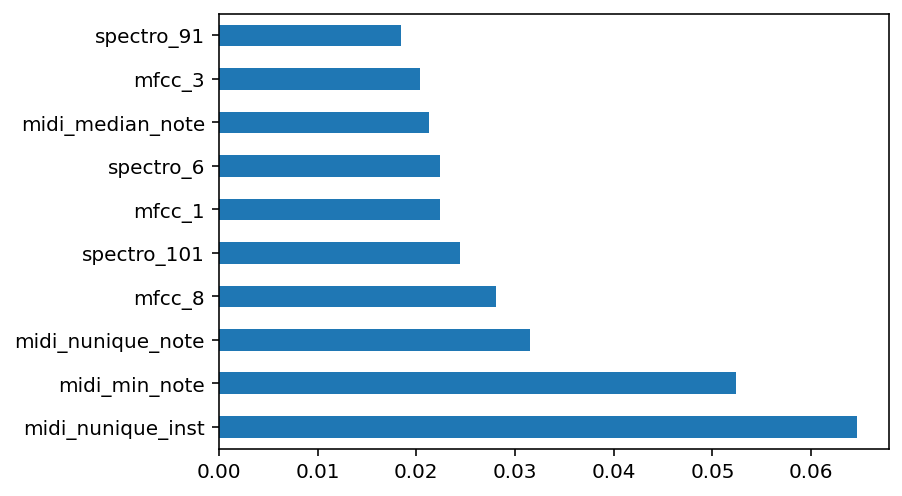

In [256]:
feat_importances = pd.Series(rf.feature_importances_, index=X_SMOTE_c.columns)
feat_importances.nlargest(10).plot(kind='barh')

### 3.a Only WAV data¶

In [260]:
rf = RandomForestClassifier(random_state=1)

model_params = {
    'n_estimators': [50, 75, 100, 125, 150, 250],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 3, 4, 5, 6]
}
clf = GridSearchCV(rf , model_params, cv=3) # set up grid search meta-estimator
clf.fit(X_SMOTE_w, y_SMOTE_w)
scores = cross_val_score(estimator = clf, X=X_SMOTE_w, y=y_SMOTE_w, cv=5, n_jobs=1)
print('Random Forest: Sample with SMOTE, hyperparameter tuning / Only WAV data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))


C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

KeyboardInterrupt: 

In [261]:
print(clf.best_params_)

{'max_features': 0.25, 'min_samples_split': 6, 'n_estimators': 150}


### 3.b Only MIDI data¶

In [263]:
rf = RandomForestClassifier(random_state=1)

model_params = {
    'n_estimators': [50, 75, 100, 125, 150, 250],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 3, 4, 5, 6]
}
clf = GridSearchCV(rf , model_params, cv=3) # set up grid search meta-estimator
clf.fit(X_SMOTE_m, y_SMOTE_m)
scores = cross_val_score(estimator = clf, X=X_SMOTE_m, y=y_SMOTE_m, cv=5, n_jobs=1)
print('Random Forest: Sample with SMOTE, hyperparameter tuning / Only MIDI data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was pas

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was pas

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was pas

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was pas

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was pas

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


Random Forest: Sample with SMOTE, hyperparameter tuning / Only MIDI data
CV Scores:  [0.99555556 1.         0.99555556 0.99555556 1.        ]
CV Average and standard deviation:  0.9973333333333333 +/- 0.002177324215807283


C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [264]:
print(clf.best_params_)

{'max_features': 0.25, 'min_samples_split': 4, 'n_estimators': 50}


In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=X_SMOTE_m.columns)
feat_importances.nlargest(10).plot(kind='barh')

### 3.c Both MIDI & WAV data

In [265]:
rf = RandomForestClassifier(random_state=1)

model_params = {
    'n_estimators': [50, 75, 100, 125, 150, 250],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 3, 4, 5, 6]
}
clf = GridSearchCV(rf , model_params, cv=3) # set up grid search meta-estimator
clf.fit(X_SMOTE_c, y_SMOTE_c)
scores = cross_val_score(estimator = clf, X=X_SMOTE_c, y=y_SMOTE_c, cv=5, n_jobs=1)
print('Random Forest: Sample with SMOTE, hyperparameter tuning / Both MIDI & WAV data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

KeyboardInterrupt: 

In [ ]:
print(clf.best_params_)